In [1]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from backbone1 import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit2 import IEViT2
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
# from cam_generate import cam_generate
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
# device = torch.device("cuda:0")
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
# patch_size = 16p
patch_size = 32
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim)
# create an instance of IEVIT
model = IEViT2(img_size= image_size, patch_size = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim,
               num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels, 0)
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels,1)
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()      

Epoch 1/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.71it/s]


Epoch [1/200], Loss: 0.2715, ML mAP: 0.0927, ML F1: 0.0225, ML AUC: 0.5474, ML Score: 0.3200, Bin AUC: 0.6111, Model Score: 0.4656, Bin F1: 0.2000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [1/200], Loss: 0.2715, ML mAP: 0.2430, ML F1: 0.0173, ML AUC: 0.7938, ML Score: 0.5184, Bin AUC: 0.7895, Model Score: 0.6539, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [2/200], Loss: 0.2283, ML mAP: 0.2164, ML F1: 0.0838, ML AUC: 0.7565, ML Score: 0.4864, Bin AUC: 0.6667, Model Score: 0.5765, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [2/200], Loss: 0.2283, ML mAP: 0.3240, ML F1: 0.1198, ML AUC: 0.8599, ML Score: 0.5919, Bin AUC: 0.2105, Model Score: 0.4012, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [3/200], Loss: 0.1903, ML mAP: 0.3389, ML F1: 0.1787, ML AUC: 0.8358, ML Score: 0.5873, Bin AUC: 0.8947, Model Score: 0.7410, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [3/200], Loss: 0.1903, ML mAP: 0.4447, ML F1: 0.1395, ML AUC: 0.8979, ML Score: 0.6713, Bin AUC: 0.7895, Model Score: 0.7304, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [4/200], Loss: 0.3032, ML mAP: 0.4747, ML F1: 0.3269, ML AUC: 0.8865, ML Score: 0.6806, Bin AUC: 0.8611, Model Score: 0.7709, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [4/200], Loss: 0.3032, ML mAP: 0.5075, ML F1: 0.2477, ML AUC: 0.9106, ML Score: 0.7091, Bin AUC: 0.7368, Model Score: 0.7230, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [5/200], Loss: 0.1746, ML mAP: 0.5881, ML F1: 0.4579, ML AUC: 0.9204, ML Score: 0.7542, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [5/200], Loss: 0.1746, ML mAP: 0.5458, ML F1: 0.3544, ML AUC: 0.9182, ML Score: 0.7320, Bin AUC: 0.4737, Model Score: 0.6028, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [6/200], Loss: 0.1964, ML mAP: 0.6752, ML F1: 0.5579, ML AUC: 0.9406, ML Score: 0.8079, Bin AUC: 0.9474, Model Score: 0.8776, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [6/200], Loss: 0.1964, ML mAP: 0.5499, ML F1: 0.3774, ML AUC: 0.9259, ML Score: 0.7379, Bin AUC: 0.7895, Model Score: 0.7637, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [7/200], Loss: 0.2493, ML mAP: 0.7504, ML F1: 0.6419, ML AUC: 0.9554, ML Score: 0.8529, Bin AUC: 1.0000, Model Score: 0.9265, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [7/200], Loss: 0.2493, ML mAP: 0.5907, ML F1: 0.4281, ML AUC: 0.9279, ML Score: 0.7593, Bin AUC: 0.3684, Model Score: 0.5639, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [8/200], Loss: 0.0992, ML mAP: 0.7841, ML F1: 0.6772, ML AUC: 0.9630, ML Score: 0.8736, Bin AUC: 0.7500, Model Score: 0.8118, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [8/200], Loss: 0.0992, ML mAP: 0.6037, ML F1: 0.4324, ML AUC: 0.9322, ML Score: 0.7680, Bin AUC: 0.3684, Model Score: 0.5682, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [9/200], Loss: 0.1187, ML mAP: 0.8215, ML F1: 0.7145, ML AUC: 0.9679, ML Score: 0.8947, Bin AUC: 0.7368, Model Score: 0.8158, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [9/200], Loss: 0.1187, ML mAP: 0.6046, ML F1: 0.4447, ML AUC: 0.9365, ML Score: 0.7705, Bin AUC: 0.3158, Model Score: 0.5432, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [10/200], Loss: 0.1134, ML mAP: 0.8310, ML F1: 0.7299, ML AUC: 0.9712, ML Score: 0.9011, Bin AUC: 1.0000, Model Score: 0.9506, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [10/200], Loss: 0.1134, ML mAP: 0.6149, ML F1: 0.4444, ML AUC: 0.9359, ML Score: 0.7754, Bin AUC: 0.4211, Model Score: 0.5982, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [11/200], Loss: 0.2359, ML mAP: 0.7501, ML F1: 0.6708, ML AUC: 0.9532, ML Score: 0.8517, Bin AUC: 0.9474, Model Score: 0.8995, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [11/200], Loss: 0.2359, ML mAP: 0.5887, ML F1: 0.4053, ML AUC: 0.9280, ML Score: 0.7584, Bin AUC: 0.3684, Model Score: 0.5634, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [12/200], Loss: 0.1438, ML mAP: 0.7576, ML F1: 0.6791, ML AUC: 0.9583, ML Score: 0.8579, Bin AUC: 0.9474, Model Score: 0.9027, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [12/200], Loss: 0.1438, ML mAP: 0.6090, ML F1: 0.5010, ML AUC: 0.9313, ML Score: 0.7702, Bin AUC: 0.2105, Model Score: 0.4904, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [13/200], Loss: 0.0571, ML mAP: 0.7974, ML F1: 0.7326, ML AUC: 0.9652, ML Score: 0.8813, Bin AUC: 1.0000, Model Score: 0.9407, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [13/200], Loss: 0.0571, ML mAP: 0.6143, ML F1: 0.4635, ML AUC: 0.9314, ML Score: 0.7729, Bin AUC: 0.4211, Model Score: 0.5970, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [14/200], Loss: 0.2686, ML mAP: 0.8398, ML F1: 0.7751, ML AUC: 0.9742, ML Score: 0.9070, Bin AUC: 1.0000, Model Score: 0.9535, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [14/200], Loss: 0.2686, ML mAP: 0.5830, ML F1: 0.4725, ML AUC: 0.9293, ML Score: 0.7562, Bin AUC: 0.6316, Model Score: 0.6939, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [15/200], Loss: 0.0865, ML mAP: 0.8699, ML F1: 0.7980, ML AUC: 0.9780, ML Score: 0.9239, Bin AUC: 1.0000, Model Score: 0.9620, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [15/200], Loss: 0.0865, ML mAP: 0.6189, ML F1: 0.5368, ML AUC: 0.9349, ML Score: 0.7769, Bin AUC: 0.8421, Model Score: 0.8095, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [16/200], Loss: 0.2998, ML mAP: 0.8844, ML F1: 0.8222, ML AUC: 0.9809, ML Score: 0.9326, Bin AUC: 1.0000, Model Score: 0.9663, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [16/200], Loss: 0.2998, ML mAP: 0.6319, ML F1: 0.5543, ML AUC: 0.9306, ML Score: 0.7813, Bin AUC: 0.6316, Model Score: 0.7064, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [17/200], Loss: 0.1853, ML mAP: 0.9044, ML F1: 0.8383, ML AUC: 0.9858, ML Score: 0.9451, Bin AUC: 1.0000, Model Score: 0.9725, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [17/200], Loss: 0.1853, ML mAP: 0.6168, ML F1: 0.5141, ML AUC: 0.9331, ML Score: 0.7749, Bin AUC: 0.5789, Model Score: 0.6769, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [18/200], Loss: 0.0632, ML mAP: 0.9198, ML F1: 0.8619, ML AUC: 0.9873, ML Score: 0.9536, Bin AUC: 1.0000, Model Score: 0.9768, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [18/200], Loss: 0.0632, ML mAP: 0.6031, ML F1: 0.5068, ML AUC: 0.9337, ML Score: 0.7684, Bin AUC: 0.5263, Model Score: 0.6474, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [19/200], Loss: 0.0493, ML mAP: 0.9326, ML F1: 0.8761, ML AUC: 0.9893, ML Score: 0.9610, Bin AUC: 1.0000, Model Score: 0.9805, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [19/200], Loss: 0.0493, ML mAP: 0.6123, ML F1: 0.5416, ML AUC: 0.9322, ML Score: 0.7723, Bin AUC: 0.8421, Model Score: 0.8072, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [20/200], Loss: 0.0486, ML mAP: 0.9425, ML F1: 0.8997, ML AUC: 0.9922, ML Score: 0.9673, Bin AUC: 1.0000, Model Score: 0.9837, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [20/200], Loss: 0.0486, ML mAP: 0.6370, ML F1: 0.5723, ML AUC: 0.9340, ML Score: 0.7855, Bin AUC: 0.8421, Model Score: 0.8138, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [21/200], Loss: 0.1121, ML mAP: 0.9550, ML F1: 0.9050, ML AUC: 0.9929, ML Score: 0.9739, Bin AUC: 1.0000, Model Score: 0.9870, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [21/200], Loss: 0.1121, ML mAP: 0.6621, ML F1: 0.5783, ML AUC: 0.9404, ML Score: 0.8013, Bin AUC: 0.8947, Model Score: 0.8480, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [22/200], Loss: 0.0833, ML mAP: 0.9617, ML F1: 0.9179, ML AUC: 0.9950, ML Score: 0.9783, Bin AUC: 1.0000, Model Score: 0.9892, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [22/200], Loss: 0.0833, ML mAP: 0.6685, ML F1: 0.5858, ML AUC: 0.9391, ML Score: 0.8038, Bin AUC: 0.7895, Model Score: 0.7966, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [23/200], Loss: 0.0885, ML mAP: 0.9688, ML F1: 0.9279, ML AUC: 0.9953, ML Score: 0.9820, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [23/200], Loss: 0.0885, ML mAP: 0.6572, ML F1: 0.5453, ML AUC: 0.9349, ML Score: 0.7961, Bin AUC: 0.7895, Model Score: 0.7928, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [24/200], Loss: 0.0346, ML mAP: 0.9677, ML F1: 0.9260, ML AUC: 0.9963, ML Score: 0.9820, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [24/200], Loss: 0.0346, ML mAP: 0.6513, ML F1: 0.5859, ML AUC: 0.9369, ML Score: 0.7941, Bin AUC: 0.8947, Model Score: 0.8444, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [25/200], Loss: 0.0695, ML mAP: 0.9815, ML F1: 0.9482, ML AUC: 0.9979, ML Score: 0.9897, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [25/200], Loss: 0.0695, ML mAP: 0.6511, ML F1: 0.5807, ML AUC: 0.9381, ML Score: 0.7946, Bin AUC: 0.8947, Model Score: 0.8447, Bin F1: 0.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [26/200], Loss: 0.0161, ML mAP: 0.9797, ML F1: 0.9437, ML AUC: 0.9973, ML Score: 0.9885, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [26/200], Loss: 0.0161, ML mAP: 0.6579, ML F1: 0.5641, ML AUC: 0.9374, ML Score: 0.7977, Bin AUC: 0.8947, Model Score: 0.8462, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [27/200], Loss: 0.0272, ML mAP: 0.9773, ML F1: 0.9432, ML AUC: 0.9972, ML Score: 0.9873, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [27/200], Loss: 0.0272, ML mAP: 0.6500, ML F1: 0.5787, ML AUC: 0.9358, ML Score: 0.7929, Bin AUC: 0.8947, Model Score: 0.8438, Bin F1: 0.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [28/200], Loss: 0.0220, ML mAP: 0.9835, ML F1: 0.9555, ML AUC: 0.9980, ML Score: 0.9908, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [28/200], Loss: 0.0220, ML mAP: 0.6491, ML F1: 0.5857, ML AUC: 0.9362, ML Score: 0.7927, Bin AUC: 0.9474, Model Score: 0.8700, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [29/200], Loss: 0.0673, ML mAP: 0.9831, ML F1: 0.9535, ML AUC: 0.9977, ML Score: 0.9904, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [29/200], Loss: 0.0673, ML mAP: 0.6495, ML F1: 0.5817, ML AUC: 0.9376, ML Score: 0.7936, Bin AUC: 0.8947, Model Score: 0.8441, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [30/200], Loss: 0.0166, ML mAP: 0.9809, ML F1: 0.9503, ML AUC: 0.9979, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [30/200], Loss: 0.0166, ML mAP: 0.6511, ML F1: 0.5727, ML AUC: 0.9375, ML Score: 0.7943, Bin AUC: 0.8947, Model Score: 0.8445, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [31/200], Loss: 0.0463, ML mAP: 0.9568, ML F1: 0.9089, ML AUC: 0.9944, ML Score: 0.9756, Bin AUC: 1.0000, Model Score: 0.9878, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [31/200], Loss: 0.0463, ML mAP: 0.6143, ML F1: 0.5641, ML AUC: 0.9361, ML Score: 0.7752, Bin AUC: 0.9474, Model Score: 0.8613, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [32/200], Loss: 0.0427, ML mAP: 0.9351, ML F1: 0.8768, ML AUC: 0.9910, ML Score: 0.9630, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [32/200], Loss: 0.0427, ML mAP: 0.6208, ML F1: 0.5676, ML AUC: 0.9365, ML Score: 0.7787, Bin AUC: 0.8421, Model Score: 0.8104, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [33/200], Loss: 0.0210, ML mAP: 0.9467, ML F1: 0.8916, ML AUC: 0.9934, ML Score: 0.9701, Bin AUC: 1.0000, Model Score: 0.9850, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [33/200], Loss: 0.0210, ML mAP: 0.6495, ML F1: 0.5794, ML AUC: 0.9335, ML Score: 0.7915, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [34/200], Loss: 0.0270, ML mAP: 0.9531, ML F1: 0.9038, ML AUC: 0.9937, ML Score: 0.9734, Bin AUC: 0.9167, Model Score: 0.9450, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [34/200], Loss: 0.0270, ML mAP: 0.6516, ML F1: 0.5953, ML AUC: 0.9353, ML Score: 0.7934, Bin AUC: 0.8421, Model Score: 0.8178, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [35/200], Loss: 0.0901, ML mAP: 0.9539, ML F1: 0.9101, ML AUC: 0.9941, ML Score: 0.9740, Bin AUC: 1.0000, Model Score: 0.9870, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [35/200], Loss: 0.0901, ML mAP: 0.6386, ML F1: 0.5538, ML AUC: 0.9354, ML Score: 0.7870, Bin AUC: 0.8947, Model Score: 0.8409, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [36/200], Loss: 0.0185, ML mAP: 0.9578, ML F1: 0.9040, ML AUC: 0.9932, ML Score: 0.9755, Bin AUC: 1.0000, Model Score: 0.9877, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [36/200], Loss: 0.0185, ML mAP: 0.6217, ML F1: 0.5532, ML AUC: 0.9348, ML Score: 0.7783, Bin AUC: 0.9474, Model Score: 0.8628, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [37/200], Loss: 0.1031, ML mAP: 0.9590, ML F1: 0.9122, ML AUC: 0.9948, ML Score: 0.9769, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [37/200], Loss: 0.1031, ML mAP: 0.5930, ML F1: 0.5227, ML AUC: 0.9288, ML Score: 0.7609, Bin AUC: 0.9474, Model Score: 0.8541, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [38/200], Loss: 0.0550, ML mAP: 0.9681, ML F1: 0.9219, ML AUC: 0.9962, ML Score: 0.9822, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [38/200], Loss: 0.0550, ML mAP: 0.6148, ML F1: 0.5503, ML AUC: 0.9301, ML Score: 0.7724, Bin AUC: 0.8947, Model Score: 0.8336, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [39/200], Loss: 0.0181, ML mAP: 0.9706, ML F1: 0.9287, ML AUC: 0.9960, ML Score: 0.9833, Bin AUC: 1.0000, Model Score: 0.9916, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [39/200], Loss: 0.0181, ML mAP: 0.6207, ML F1: 0.5597, ML AUC: 0.9270, ML Score: 0.7739, Bin AUC: 0.9474, Model Score: 0.8606, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [40/200], Loss: 0.0580, ML mAP: 0.9755, ML F1: 0.9335, ML AUC: 0.9967, ML Score: 0.9861, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [40/200], Loss: 0.0580, ML mAP: 0.6433, ML F1: 0.5701, ML AUC: 0.9339, ML Score: 0.7886, Bin AUC: 0.9474, Model Score: 0.8680, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [41/200], Loss: 0.0804, ML mAP: 0.9832, ML F1: 0.9465, ML AUC: 0.9978, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [41/200], Loss: 0.0804, ML mAP: 0.6283, ML F1: 0.5713, ML AUC: 0.9237, ML Score: 0.7760, Bin AUC: 0.8421, Model Score: 0.8091, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [42/200], Loss: 0.0244, ML mAP: 0.9797, ML F1: 0.9409, ML AUC: 0.9976, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [42/200], Loss: 0.0244, ML mAP: 0.6364, ML F1: 0.5561, ML AUC: 0.9333, ML Score: 0.7849, Bin AUC: 0.9474, Model Score: 0.8661, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [43/200], Loss: 0.1837, ML mAP: 0.9777, ML F1: 0.9474, ML AUC: 0.9975, ML Score: 0.9876, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [43/200], Loss: 0.1837, ML mAP: 0.6317, ML F1: 0.5937, ML AUC: 0.9420, ML Score: 0.7869, Bin AUC: 0.9474, Model Score: 0.8671, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [44/200], Loss: 0.0972, ML mAP: 0.9785, ML F1: 0.9468, ML AUC: 0.9975, ML Score: 0.9880, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [44/200], Loss: 0.0972, ML mAP: 0.6442, ML F1: 0.6026, ML AUC: 0.9347, ML Score: 0.7894, Bin AUC: 0.9474, Model Score: 0.8684, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [45/200], Loss: 0.0196, ML mAP: 0.9826, ML F1: 0.9512, ML AUC: 0.9980, ML Score: 0.9903, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [45/200], Loss: 0.0196, ML mAP: 0.6387, ML F1: 0.5977, ML AUC: 0.9350, ML Score: 0.7869, Bin AUC: 0.8421, Model Score: 0.8145, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [46/200], Loss: 0.0608, ML mAP: 0.9871, ML F1: 0.9581, ML AUC: 0.9986, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [46/200], Loss: 0.0608, ML mAP: 0.6480, ML F1: 0.5857, ML AUC: 0.9282, ML Score: 0.7881, Bin AUC: 0.7895, Model Score: 0.7888, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [47/200], Loss: 0.0615, ML mAP: 0.9906, ML F1: 0.9638, ML AUC: 0.9990, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [47/200], Loss: 0.0615, ML mAP: 0.6524, ML F1: 0.5759, ML AUC: 0.9268, ML Score: 0.7896, Bin AUC: 0.8947, Model Score: 0.8422, Bin F1: 0.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [48/200], Loss: 0.0563, ML mAP: 0.9850, ML F1: 0.9622, ML AUC: 0.9986, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [48/200], Loss: 0.0563, ML mAP: 0.6441, ML F1: 0.5822, ML AUC: 0.9306, ML Score: 0.7874, Bin AUC: 0.7895, Model Score: 0.7884, Bin F1: 0.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [49/200], Loss: 0.0318, ML mAP: 0.9891, ML F1: 0.9658, ML AUC: 0.9989, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [49/200], Loss: 0.0318, ML mAP: 0.6381, ML F1: 0.5923, ML AUC: 0.9281, ML Score: 0.7831, Bin AUC: 0.8947, Model Score: 0.8389, Bin F1: 0.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [50/200], Loss: 0.0663, ML mAP: 0.9939, ML F1: 0.9716, ML AUC: 0.9994, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [50/200], Loss: 0.0663, ML mAP: 0.6514, ML F1: 0.6058, ML AUC: 0.9322, ML Score: 0.7918, Bin AUC: 0.8947, Model Score: 0.8433, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [51/200], Loss: 0.0996, ML mAP: 0.9922, ML F1: 0.9715, ML AUC: 0.9992, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [51/200], Loss: 0.0996, ML mAP: 0.6473, ML F1: 0.5809, ML AUC: 0.9336, ML Score: 0.7905, Bin AUC: 0.8421, Model Score: 0.8163, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [52/200], Loss: 0.0221, ML mAP: 0.9935, ML F1: 0.9738, ML AUC: 0.9993, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [52/200], Loss: 0.0221, ML mAP: 0.6419, ML F1: 0.5924, ML AUC: 0.9340, ML Score: 0.7880, Bin AUC: 0.8421, Model Score: 0.8150, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [53/200], Loss: 0.0024, ML mAP: 0.9948, ML F1: 0.9772, ML AUC: 0.9995, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [53/200], Loss: 0.0024, ML mAP: 0.6545, ML F1: 0.5994, ML AUC: 0.9352, ML Score: 0.7948, Bin AUC: 0.8947, Model Score: 0.8448, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [54/200], Loss: 0.3326, ML mAP: 0.9939, ML F1: 0.9755, ML AUC: 0.9995, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [54/200], Loss: 0.3326, ML mAP: 0.6519, ML F1: 0.5884, ML AUC: 0.9408, ML Score: 0.7964, Bin AUC: 0.8947, Model Score: 0.8456, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [55/200], Loss: 0.0267, ML mAP: 0.9950, ML F1: 0.9775, ML AUC: 0.9995, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [55/200], Loss: 0.0267, ML mAP: 0.6517, ML F1: 0.6035, ML AUC: 0.9407, ML Score: 0.7962, Bin AUC: 0.8947, Model Score: 0.8455, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [56/200], Loss: 0.0551, ML mAP: 0.9952, ML F1: 0.9796, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [56/200], Loss: 0.0551, ML mAP: 0.6454, ML F1: 0.6161, ML AUC: 0.9378, ML Score: 0.7916, Bin AUC: 0.8947, Model Score: 0.8432, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [57/200], Loss: 0.0043, ML mAP: 0.9955, ML F1: 0.9831, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [57/200], Loss: 0.0043, ML mAP: 0.6380, ML F1: 0.6075, ML AUC: 0.9383, ML Score: 0.7881, Bin AUC: 0.8947, Model Score: 0.8414, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [58/200], Loss: 0.0434, ML mAP: 0.9954, ML F1: 0.9780, ML AUC: 0.9997, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [58/200], Loss: 0.0434, ML mAP: 0.6403, ML F1: 0.5996, ML AUC: 0.9399, ML Score: 0.7901, Bin AUC: 0.8947, Model Score: 0.8424, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [59/200], Loss: 0.0032, ML mAP: 0.9968, ML F1: 0.9820, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [59/200], Loss: 0.0032, ML mAP: 0.6453, ML F1: 0.6017, ML AUC: 0.9366, ML Score: 0.7909, Bin AUC: 0.8947, Model Score: 0.8428, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [60/200], Loss: 0.0047, ML mAP: 0.9956, ML F1: 0.9830, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [60/200], Loss: 0.0047, ML mAP: 0.6531, ML F1: 0.6025, ML AUC: 0.9388, ML Score: 0.7959, Bin AUC: 0.9474, Model Score: 0.8717, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [61/200], Loss: 0.0193, ML mAP: 0.9973, ML F1: 0.9833, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [61/200], Loss: 0.0193, ML mAP: 0.6369, ML F1: 0.6040, ML AUC: 0.9375, ML Score: 0.7872, Bin AUC: 0.8947, Model Score: 0.8410, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [62/200], Loss: 0.0148, ML mAP: 0.9968, ML F1: 0.9845, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [62/200], Loss: 0.0148, ML mAP: 0.6395, ML F1: 0.5972, ML AUC: 0.9390, ML Score: 0.7893, Bin AUC: 0.8421, Model Score: 0.8157, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [63/200], Loss: 0.0067, ML mAP: 0.9958, ML F1: 0.9826, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [63/200], Loss: 0.0067, ML mAP: 0.6428, ML F1: 0.5999, ML AUC: 0.9401, ML Score: 0.7915, Bin AUC: 0.8947, Model Score: 0.8431, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [64/200], Loss: 0.0867, ML mAP: 0.9987, ML F1: 0.9901, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [64/200], Loss: 0.0867, ML mAP: 0.6411, ML F1: 0.6109, ML AUC: 0.9397, ML Score: 0.7904, Bin AUC: 0.8947, Model Score: 0.8426, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [65/200], Loss: 0.2329, ML mAP: 0.9984, ML F1: 0.9914, ML AUC: 0.9997, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [65/200], Loss: 0.2329, ML mAP: 0.6544, ML F1: 0.5987, ML AUC: 0.9404, ML Score: 0.7974, Bin AUC: 0.8947, Model Score: 0.8461, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [66/200], Loss: 0.0823, ML mAP: 0.9986, ML F1: 0.9885, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [66/200], Loss: 0.0823, ML mAP: 0.6428, ML F1: 0.6053, ML AUC: 0.9407, ML Score: 0.7917, Bin AUC: 0.8947, Model Score: 0.8432, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [67/200], Loss: 0.0025, ML mAP: 0.9984, ML F1: 0.9878, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [67/200], Loss: 0.0025, ML mAP: 0.6450, ML F1: 0.6141, ML AUC: 0.9417, ML Score: 0.7934, Bin AUC: 0.8947, Model Score: 0.8441, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [68/200], Loss: 0.0012, ML mAP: 0.9982, ML F1: 0.9890, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [68/200], Loss: 0.0012, ML mAP: 0.6545, ML F1: 0.6056, ML AUC: 0.9429, ML Score: 0.7987, Bin AUC: 0.8947, Model Score: 0.8467, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [69/200], Loss: 0.0017, ML mAP: 0.9985, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [69/200], Loss: 0.0017, ML mAP: 0.6432, ML F1: 0.5962, ML AUC: 0.9409, ML Score: 0.7920, Bin AUC: 0.8947, Model Score: 0.8434, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [70/200], Loss: 0.0283, ML mAP: 0.9982, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [70/200], Loss: 0.0283, ML mAP: 0.6438, ML F1: 0.6100, ML AUC: 0.9413, ML Score: 0.7925, Bin AUC: 0.8947, Model Score: 0.8436, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [71/200], Loss: 0.0323, ML mAP: 0.9793, ML F1: 0.9493, ML AUC: 0.9973, ML Score: 0.9883, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [71/200], Loss: 0.0323, ML mAP: 0.6454, ML F1: 0.5697, ML AUC: 0.9369, ML Score: 0.7911, Bin AUC: 0.5789, Model Score: 0.6850, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [72/200], Loss: 0.0216, ML mAP: 0.9747, ML F1: 0.9269, ML AUC: 0.9963, ML Score: 0.9855, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [72/200], Loss: 0.0216, ML mAP: 0.6347, ML F1: 0.5656, ML AUC: 0.9295, ML Score: 0.7821, Bin AUC: 0.8421, Model Score: 0.8121, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [73/200], Loss: 0.0609, ML mAP: 0.9765, ML F1: 0.9360, ML AUC: 0.9963, ML Score: 0.9864, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [73/200], Loss: 0.0609, ML mAP: 0.6333, ML F1: 0.5867, ML AUC: 0.9315, ML Score: 0.7824, Bin AUC: 0.9474, Model Score: 0.8649, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [74/200], Loss: 0.0199, ML mAP: 0.9754, ML F1: 0.9348, ML AUC: 0.9970, ML Score: 0.9862, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [74/200], Loss: 0.0199, ML mAP: 0.6002, ML F1: 0.5254, ML AUC: 0.9161, ML Score: 0.7582, Bin AUC: 0.9474, Model Score: 0.8528, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [75/200], Loss: 0.0836, ML mAP: 0.9811, ML F1: 0.9377, ML AUC: 0.9977, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [75/200], Loss: 0.0836, ML mAP: 0.6252, ML F1: 0.5945, ML AUC: 0.9241, ML Score: 0.7747, Bin AUC: 0.9474, Model Score: 0.8610, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [76/200], Loss: 0.0328, ML mAP: 0.9790, ML F1: 0.9397, ML AUC: 0.9974, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [76/200], Loss: 0.0328, ML mAP: 0.6239, ML F1: 0.5751, ML AUC: 0.9237, ML Score: 0.7738, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [77/200], Loss: 0.0016, ML mAP: 0.9838, ML F1: 0.9515, ML AUC: 0.9979, ML Score: 0.9909, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [77/200], Loss: 0.0016, ML mAP: 0.6399, ML F1: 0.5859, ML AUC: 0.9306, ML Score: 0.7852, Bin AUC: 0.9474, Model Score: 0.8663, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [78/200], Loss: 0.2039, ML mAP: 0.9865, ML F1: 0.9590, ML AUC: 0.9983, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [78/200], Loss: 0.2039, ML mAP: 0.6518, ML F1: 0.6050, ML AUC: 0.9327, ML Score: 0.7922, Bin AUC: 0.9474, Model Score: 0.8698, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [79/200], Loss: 0.0166, ML mAP: 0.9830, ML F1: 0.9521, ML AUC: 0.9980, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [79/200], Loss: 0.0166, ML mAP: 0.6349, ML F1: 0.5609, ML AUC: 0.9259, ML Score: 0.7804, Bin AUC: 0.8421, Model Score: 0.8113, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [80/200], Loss: 0.0163, ML mAP: 0.9876, ML F1: 0.9604, ML AUC: 0.9986, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [80/200], Loss: 0.0163, ML mAP: 0.6446, ML F1: 0.5991, ML AUC: 0.9306, ML Score: 0.7876, Bin AUC: 0.9474, Model Score: 0.8675, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [81/200], Loss: 0.0667, ML mAP: 0.9873, ML F1: 0.9578, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [81/200], Loss: 0.0667, ML mAP: 0.6443, ML F1: 0.5743, ML AUC: 0.9234, ML Score: 0.7838, Bin AUC: 0.9474, Model Score: 0.8656, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [82/200], Loss: 0.0071, ML mAP: 0.9888, ML F1: 0.9551, ML AUC: 0.9986, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [82/200], Loss: 0.0071, ML mAP: 0.6229, ML F1: 0.5594, ML AUC: 0.9184, ML Score: 0.7706, Bin AUC: 0.9474, Model Score: 0.8590, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [83/200], Loss: 0.0087, ML mAP: 0.9895, ML F1: 0.9617, ML AUC: 0.9988, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [83/200], Loss: 0.0087, ML mAP: 0.6358, ML F1: 0.5863, ML AUC: 0.9260, ML Score: 0.7809, Bin AUC: 0.8421, Model Score: 0.8115, Bin F1: 0.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [84/200], Loss: 0.0100, ML mAP: 0.9936, ML F1: 0.9733, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [84/200], Loss: 0.0100, ML mAP: 0.6422, ML F1: 0.5897, ML AUC: 0.9220, ML Score: 0.7821, Bin AUC: 0.8421, Model Score: 0.8121, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [85/200], Loss: 0.0383, ML mAP: 0.9941, ML F1: 0.9754, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [85/200], Loss: 0.0383, ML mAP: 0.6400, ML F1: 0.6007, ML AUC: 0.9326, ML Score: 0.7863, Bin AUC: 0.8421, Model Score: 0.8142, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [86/200], Loss: 0.0119, ML mAP: 0.9880, ML F1: 0.9593, ML AUC: 0.9988, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [86/200], Loss: 0.0119, ML mAP: 0.6443, ML F1: 0.5688, ML AUC: 0.9275, ML Score: 0.7859, Bin AUC: 0.8947, Model Score: 0.8403, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [87/200], Loss: 0.0408, ML mAP: 0.9941, ML F1: 0.9698, ML AUC: 0.9995, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [87/200], Loss: 0.0408, ML mAP: 0.6455, ML F1: 0.5668, ML AUC: 0.9357, ML Score: 0.7906, Bin AUC: 0.9474, Model Score: 0.8690, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [88/200], Loss: 0.0041, ML mAP: 0.9903, ML F1: 0.9668, ML AUC: 0.9986, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 0.8000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [88/200], Loss: 0.0041, ML mAP: 0.6366, ML F1: 0.5856, ML AUC: 0.9302, ML Score: 0.7834, Bin AUC: 0.8947, Model Score: 0.8391, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [89/200], Loss: 0.0417, ML mAP: 0.9920, ML F1: 0.9681, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [89/200], Loss: 0.0417, ML mAP: 0.6208, ML F1: 0.5748, ML AUC: 0.9249, ML Score: 0.7729, Bin AUC: 1.0000, Model Score: 0.8864, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [90/200], Loss: 0.3762, ML mAP: 0.9906, ML F1: 0.9647, ML AUC: 0.9989, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [90/200], Loss: 0.3762, ML mAP: 0.6362, ML F1: 0.5774, ML AUC: 0.9345, ML Score: 0.7854, Bin AUC: 0.9474, Model Score: 0.8664, Bin F1: 0.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [91/200], Loss: 0.0961, ML mAP: 0.9829, ML F1: 0.9504, ML AUC: 0.9982, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [91/200], Loss: 0.0961, ML mAP: 0.6288, ML F1: 0.5755, ML AUC: 0.9324, ML Score: 0.7806, Bin AUC: 0.8421, Model Score: 0.8114, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [92/200], Loss: 0.0479, ML mAP: 0.9913, ML F1: 0.9697, ML AUC: 0.9992, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [92/200], Loss: 0.0479, ML mAP: 0.6505, ML F1: 0.6121, ML AUC: 0.9380, ML Score: 0.7942, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [93/200], Loss: 0.0385, ML mAP: 0.9915, ML F1: 0.9670, ML AUC: 0.9993, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [93/200], Loss: 0.0385, ML mAP: 0.6344, ML F1: 0.6007, ML AUC: 0.9312, ML Score: 0.7828, Bin AUC: 0.9474, Model Score: 0.8651, Bin F1: 0.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [94/200], Loss: 0.0721, ML mAP: 0.9952, ML F1: 0.9783, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [94/200], Loss: 0.0721, ML mAP: 0.6328, ML F1: 0.5830, ML AUC: 0.9320, ML Score: 0.7824, Bin AUC: 1.0000, Model Score: 0.8912, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [95/200], Loss: 0.0482, ML mAP: 0.9956, ML F1: 0.9743, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [95/200], Loss: 0.0482, ML mAP: 0.6361, ML F1: 0.5797, ML AUC: 0.9333, ML Score: 0.7847, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [96/200], Loss: 0.0020, ML mAP: 0.9945, ML F1: 0.9705, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [96/200], Loss: 0.0020, ML mAP: 0.6552, ML F1: 0.6248, ML AUC: 0.9352, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [97/200], Loss: 0.0436, ML mAP: 0.9945, ML F1: 0.9757, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [97/200], Loss: 0.0436, ML mAP: 0.6457, ML F1: 0.6230, ML AUC: 0.9345, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [98/200], Loss: 0.0228, ML mAP: 0.9965, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 0.6667


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [98/200], Loss: 0.0228, ML mAP: 0.6424, ML F1: 0.5965, ML AUC: 0.9416, ML Score: 0.7920, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [99/200], Loss: 0.0261, ML mAP: 0.9942, ML F1: 0.9770, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [99/200], Loss: 0.0261, ML mAP: 0.6426, ML F1: 0.5850, ML AUC: 0.9344, ML Score: 0.7885, Bin AUC: 0.9474, Model Score: 0.8679, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [100/200], Loss: 0.0007, ML mAP: 0.9963, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [100/200], Loss: 0.0007, ML mAP: 0.6481, ML F1: 0.5963, ML AUC: 0.9353, ML Score: 0.7917, Bin AUC: 0.9474, Model Score: 0.8695, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [101/200], Loss: 0.0056, ML mAP: 0.9983, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [101/200], Loss: 0.0056, ML mAP: 0.6555, ML F1: 0.5964, ML AUC: 0.9354, ML Score: 0.7955, Bin AUC: 0.9474, Model Score: 0.8714, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [102/200], Loss: 0.0074, ML mAP: 0.9971, ML F1: 0.9824, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [102/200], Loss: 0.0074, ML mAP: 0.6362, ML F1: 0.5894, ML AUC: 0.9305, ML Score: 0.7834, Bin AUC: 0.9474, Model Score: 0.8654, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [103/200], Loss: 0.1862, ML mAP: 0.9968, ML F1: 0.9830, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [103/200], Loss: 0.1862, ML mAP: 0.6397, ML F1: 0.5945, ML AUC: 0.9365, ML Score: 0.7881, Bin AUC: 0.8947, Model Score: 0.8414, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [104/200], Loss: 0.0209, ML mAP: 0.9963, ML F1: 0.9815, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [104/200], Loss: 0.0209, ML mAP: 0.6392, ML F1: 0.5963, ML AUC: 0.9343, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [105/200], Loss: 0.0015, ML mAP: 0.9947, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [105/200], Loss: 0.0015, ML mAP: 0.6515, ML F1: 0.6051, ML AUC: 0.9356, ML Score: 0.7935, Bin AUC: 1.0000, Model Score: 0.8968, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [106/200], Loss: 0.0364, ML mAP: 0.9962, ML F1: 0.9836, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [106/200], Loss: 0.0364, ML mAP: 0.6446, ML F1: 0.6172, ML AUC: 0.9315, ML Score: 0.7881, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [107/200], Loss: 0.0196, ML mAP: 0.9970, ML F1: 0.9820, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [107/200], Loss: 0.0196, ML mAP: 0.6399, ML F1: 0.5964, ML AUC: 0.9323, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [108/200], Loss: 0.0024, ML mAP: 0.9975, ML F1: 0.9891, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [108/200], Loss: 0.0024, ML mAP: 0.6468, ML F1: 0.6093, ML AUC: 0.9297, ML Score: 0.7883, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [109/200], Loss: 0.0079, ML mAP: 0.9988, ML F1: 0.9889, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [109/200], Loss: 0.0079, ML mAP: 0.6413, ML F1: 0.6081, ML AUC: 0.9272, ML Score: 0.7842, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [110/200], Loss: 0.0615, ML mAP: 0.9983, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [110/200], Loss: 0.0615, ML mAP: 0.6455, ML F1: 0.5877, ML AUC: 0.9316, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 0.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [111/200], Loss: 0.0055, ML mAP: 0.9983, ML F1: 0.9886, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [111/200], Loss: 0.0055, ML mAP: 0.6398, ML F1: 0.5886, ML AUC: 0.9319, ML Score: 0.7859, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 0.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [112/200], Loss: 0.0736, ML mAP: 0.9979, ML F1: 0.9893, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [112/200], Loss: 0.0736, ML mAP: 0.6365, ML F1: 0.5999, ML AUC: 0.9296, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [113/200], Loss: 0.0424, ML mAP: 0.9992, ML F1: 0.9913, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [113/200], Loss: 0.0424, ML mAP: 0.6498, ML F1: 0.5987, ML AUC: 0.9316, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [114/200], Loss: 0.2346, ML mAP: 0.9985, ML F1: 0.9888, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [114/200], Loss: 0.2346, ML mAP: 0.6520, ML F1: 0.6176, ML AUC: 0.9306, ML Score: 0.7913, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [115/200], Loss: 0.0379, ML mAP: 0.9985, ML F1: 0.9867, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [115/200], Loss: 0.0379, ML mAP: 0.6507, ML F1: 0.6209, ML AUC: 0.9300, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [116/200], Loss: 0.0981, ML mAP: 0.9975, ML F1: 0.9872, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [116/200], Loss: 0.0981, ML mAP: 0.6600, ML F1: 0.6112, ML AUC: 0.9307, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 0.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [117/200], Loss: 0.0101, ML mAP: 0.9977, ML F1: 0.9872, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [117/200], Loss: 0.0101, ML mAP: 0.6477, ML F1: 0.6155, ML AUC: 0.9299, ML Score: 0.7888, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [118/200], Loss: 0.0032, ML mAP: 0.9988, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [118/200], Loss: 0.0032, ML mAP: 0.6603, ML F1: 0.5878, ML AUC: 0.9292, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [119/200], Loss: 0.0009, ML mAP: 0.9990, ML F1: 0.9891, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [119/200], Loss: 0.0009, ML mAP: 0.6639, ML F1: 0.5955, ML AUC: 0.9312, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [120/200], Loss: 0.0341, ML mAP: 0.9994, ML F1: 0.9939, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 0.9474, Model Score: 0.9735, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Val - Epoch [120/200], Loss: 0.0341, ML mAP: 0.6663, ML F1: 0.6120, ML AUC: 0.9335, ML Score: 0.7999, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [121/200], Loss: 0.0276, ML mAP: 0.9989, ML F1: 0.9922, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [121/200], Loss: 0.0276, ML mAP: 0.6591, ML F1: 0.6092, ML AUC: 0.9314, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [122/200], Loss: 0.1277, ML mAP: 0.9993, ML F1: 0.9924, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [122/200], Loss: 0.1277, ML mAP: 0.6633, ML F1: 0.6204, ML AUC: 0.9363, ML Score: 0.7998, Bin AUC: 1.0000, Model Score: 0.8999, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [123/200], Loss: 0.0016, ML mAP: 0.9991, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [123/200], Loss: 0.0016, ML mAP: 0.6705, ML F1: 0.6202, ML AUC: 0.9370, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [124/200], Loss: 0.1463, ML mAP: 0.9994, ML F1: 0.9956, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [124/200], Loss: 0.1463, ML mAP: 0.6730, ML F1: 0.6278, ML AUC: 0.9362, ML Score: 0.8046, Bin AUC: 1.0000, Model Score: 0.9023, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [125/200], Loss: 0.0084, ML mAP: 0.9990, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [125/200], Loss: 0.0084, ML mAP: 0.6730, ML F1: 0.6216, ML AUC: 0.9365, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [126/200], Loss: 0.0006, ML mAP: 0.9994, ML F1: 0.9922, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [126/200], Loss: 0.0006, ML mAP: 0.6760, ML F1: 0.6157, ML AUC: 0.9382, ML Score: 0.8071, Bin AUC: 0.9474, Model Score: 0.8772, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [127/200], Loss: 0.0008, ML mAP: 0.9994, ML F1: 0.9950, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [127/200], Loss: 0.0008, ML mAP: 0.6708, ML F1: 0.5956, ML AUC: 0.9338, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [128/200], Loss: 0.0050, ML mAP: 0.9983, ML F1: 0.9961, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [128/200], Loss: 0.0050, ML mAP: 0.6779, ML F1: 0.6043, ML AUC: 0.9351, ML Score: 0.8065, Bin AUC: 1.0000, Model Score: 0.9033, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [129/200], Loss: 0.0025, ML mAP: 0.9997, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [129/200], Loss: 0.0025, ML mAP: 0.6777, ML F1: 0.6061, ML AUC: 0.9350, ML Score: 0.8064, Bin AUC: 1.0000, Model Score: 0.9032, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [130/200], Loss: 0.0009, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [130/200], Loss: 0.0009, ML mAP: 0.6703, ML F1: 0.6131, ML AUC: 0.9349, ML Score: 0.8026, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [131/200], Loss: 0.0060, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [131/200], Loss: 0.0060, ML mAP: 0.6742, ML F1: 0.6159, ML AUC: 0.9374, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [132/200], Loss: 0.1926, ML mAP: 0.9996, ML F1: 0.9958, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [132/200], Loss: 0.1926, ML mAP: 0.6759, ML F1: 0.6238, ML AUC: 0.9387, ML Score: 0.8073, Bin AUC: 1.0000, Model Score: 0.9037, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [133/200], Loss: 0.0416, ML mAP: 0.9998, ML F1: 0.9943, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [133/200], Loss: 0.0416, ML mAP: 0.6730, ML F1: 0.6159, ML AUC: 0.9340, ML Score: 0.8035, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [134/200], Loss: 0.0099, ML mAP: 0.9989, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [134/200], Loss: 0.0099, ML mAP: 0.6723, ML F1: 0.6183, ML AUC: 0.9351, ML Score: 0.8037, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [135/200], Loss: 0.0002, ML mAP: 0.9993, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [135/200], Loss: 0.0002, ML mAP: 0.6782, ML F1: 0.6243, ML AUC: 0.9358, ML Score: 0.8070, Bin AUC: 1.0000, Model Score: 0.9035, Bin F1: 1.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [136/200], Loss: 0.0096, ML mAP: 0.9999, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [136/200], Loss: 0.0096, ML mAP: 0.6739, ML F1: 0.6255, ML AUC: 0.9366, ML Score: 0.8052, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [137/200], Loss: 0.0022, ML mAP: 0.9996, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [137/200], Loss: 0.0022, ML mAP: 0.6741, ML F1: 0.6226, ML AUC: 0.9375, ML Score: 0.8058, Bin AUC: 1.0000, Model Score: 0.9029, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [138/200], Loss: 0.0004, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [138/200], Loss: 0.0004, ML mAP: 0.6697, ML F1: 0.6107, ML AUC: 0.9353, ML Score: 0.8025, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [139/200], Loss: 0.0013, ML mAP: 0.9997, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [139/200], Loss: 0.0013, ML mAP: 0.6719, ML F1: 0.6319, ML AUC: 0.9366, ML Score: 0.8042, Bin AUC: 1.0000, Model Score: 0.9021, Bin F1: 0.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [140/200], Loss: 0.0029, ML mAP: 0.9997, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [140/200], Loss: 0.0029, ML mAP: 0.6754, ML F1: 0.6278, ML AUC: 0.9355, ML Score: 0.8055, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [141/200], Loss: 0.0051, ML mAP: 0.9999, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [141/200], Loss: 0.0051, ML mAP: 0.6734, ML F1: 0.6205, ML AUC: 0.9368, ML Score: 0.8051, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 1.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [142/200], Loss: 0.0182, ML mAP: 0.9997, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [142/200], Loss: 0.0182, ML mAP: 0.6688, ML F1: 0.6225, ML AUC: 0.9358, ML Score: 0.8023, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 0.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [143/200], Loss: 0.1719, ML mAP: 0.9998, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [143/200], Loss: 0.1719, ML mAP: 0.6737, ML F1: 0.6216, ML AUC: 0.9343, ML Score: 0.8040, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [144/200], Loss: 0.0412, ML mAP: 0.9997, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [144/200], Loss: 0.0412, ML mAP: 0.6722, ML F1: 0.6105, ML AUC: 0.9345, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [145/200], Loss: 0.0093, ML mAP: 0.9999, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [145/200], Loss: 0.0093, ML mAP: 0.6718, ML F1: 0.6136, ML AUC: 0.9364, ML Score: 0.8041, Bin AUC: 1.0000, Model Score: 0.9020, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [146/200], Loss: 0.0054, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [146/200], Loss: 0.0054, ML mAP: 0.6664, ML F1: 0.6171, ML AUC: 0.9344, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [147/200], Loss: 0.0075, ML mAP: 1.0000, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [147/200], Loss: 0.0075, ML mAP: 0.6679, ML F1: 0.6135, ML AUC: 0.9350, ML Score: 0.8014, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [148/200], Loss: 0.0081, ML mAP: 0.9996, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [148/200], Loss: 0.0081, ML mAP: 0.6699, ML F1: 0.6260, ML AUC: 0.9373, ML Score: 0.8036, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 1.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [149/200], Loss: 0.0005, ML mAP: 0.9996, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [149/200], Loss: 0.0005, ML mAP: 0.6672, ML F1: 0.6150, ML AUC: 0.9352, ML Score: 0.8012, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [150/200], Loss: 0.0064, ML mAP: 0.9998, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [150/200], Loss: 0.0064, ML mAP: 0.6741, ML F1: 0.6182, ML AUC: 0.9366, ML Score: 0.8054, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 0.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [151/200], Loss: 0.0800, ML mAP: 0.9918, ML F1: 0.9661, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [151/200], Loss: 0.0800, ML mAP: 0.6075, ML F1: 0.5296, ML AUC: 0.9181, ML Score: 0.7628, Bin AUC: 0.8947, Model Score: 0.8288, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [152/200], Loss: 0.1190, ML mAP: 0.9715, ML F1: 0.9198, ML AUC: 0.9961, ML Score: 0.9838, Bin AUC: 1.0000, Model Score: 0.9919, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [152/200], Loss: 0.1190, ML mAP: 0.5931, ML F1: 0.5499, ML AUC: 0.8994, ML Score: 0.7462, Bin AUC: 1.0000, Model Score: 0.8731, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [153/200], Loss: 0.0408, ML mAP: 0.9849, ML F1: 0.9493, ML AUC: 0.9983, ML Score: 0.9916, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [153/200], Loss: 0.0408, ML mAP: 0.6232, ML F1: 0.5421, ML AUC: 0.9186, ML Score: 0.7709, Bin AUC: 0.9474, Model Score: 0.8591, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [154/200], Loss: 0.0616, ML mAP: 0.9902, ML F1: 0.9566, ML AUC: 0.9988, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [154/200], Loss: 0.0616, ML mAP: 0.6169, ML F1: 0.5873, ML AUC: 0.9238, ML Score: 0.7703, Bin AUC: 1.0000, Model Score: 0.8852, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [155/200], Loss: 0.0404, ML mAP: 0.9904, ML F1: 0.9634, ML AUC: 0.9988, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [155/200], Loss: 0.0404, ML mAP: 0.6231, ML F1: 0.5514, ML AUC: 0.9210, ML Score: 0.7721, Bin AUC: 0.9474, Model Score: 0.8597, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [156/200], Loss: 0.0115, ML mAP: 0.9914, ML F1: 0.9666, ML AUC: 0.9991, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [156/200], Loss: 0.0115, ML mAP: 0.6267, ML F1: 0.5721, ML AUC: 0.9245, ML Score: 0.7756, Bin AUC: 0.9474, Model Score: 0.8615, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [157/200], Loss: 0.0188, ML mAP: 0.9944, ML F1: 0.9709, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [157/200], Loss: 0.0188, ML mAP: 0.6293, ML F1: 0.5546, ML AUC: 0.9204, ML Score: 0.7748, Bin AUC: 0.9474, Model Score: 0.8611, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [158/200], Loss: 0.0038, ML mAP: 0.9909, ML F1: 0.9635, ML AUC: 0.9991, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [158/200], Loss: 0.0038, ML mAP: 0.6355, ML F1: 0.5796, ML AUC: 0.9254, ML Score: 0.7805, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 0.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [159/200], Loss: 0.0580, ML mAP: 0.9934, ML F1: 0.9726, ML AUC: 0.9991, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [159/200], Loss: 0.0580, ML mAP: 0.6196, ML F1: 0.5452, ML AUC: 0.9201, ML Score: 0.7698, Bin AUC: 0.9474, Model Score: 0.8586, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [160/200], Loss: 0.0251, ML mAP: 0.9940, ML F1: 0.9760, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [160/200], Loss: 0.0251, ML mAP: 0.6293, ML F1: 0.5965, ML AUC: 0.9229, ML Score: 0.7761, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [161/200], Loss: 0.0152, ML mAP: 0.9891, ML F1: 0.9615, ML AUC: 0.9987, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [161/200], Loss: 0.0152, ML mAP: 0.6107, ML F1: 0.5824, ML AUC: 0.9229, ML Score: 0.7668, Bin AUC: 1.0000, Model Score: 0.8834, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [162/200], Loss: 0.0021, ML mAP: 0.9935, ML F1: 0.9736, ML AUC: 0.9994, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [162/200], Loss: 0.0021, ML mAP: 0.6331, ML F1: 0.5577, ML AUC: 0.9327, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 0.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [163/200], Loss: 0.0206, ML mAP: 0.9940, ML F1: 0.9754, ML AUC: 0.9996, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [163/200], Loss: 0.0206, ML mAP: 0.6245, ML F1: 0.5401, ML AUC: 0.9230, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [164/200], Loss: 0.0049, ML mAP: 0.9944, ML F1: 0.9780, ML AUC: 0.9995, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [164/200], Loss: 0.0049, ML mAP: 0.6301, ML F1: 0.5663, ML AUC: 0.9348, ML Score: 0.7824, Bin AUC: 1.0000, Model Score: 0.8912, Bin F1: 1.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [165/200], Loss: 0.0040, ML mAP: 0.9966, ML F1: 0.9819, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [165/200], Loss: 0.0040, ML mAP: 0.6262, ML F1: 0.5684, ML AUC: 0.9292, ML Score: 0.7777, Bin AUC: 1.0000, Model Score: 0.8889, Bin F1: 1.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [166/200], Loss: 0.0313, ML mAP: 0.9947, ML F1: 0.9754, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [166/200], Loss: 0.0313, ML mAP: 0.6164, ML F1: 0.5576, ML AUC: 0.9200, ML Score: 0.7682, Bin AUC: 1.0000, Model Score: 0.8841, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [167/200], Loss: 0.0018, ML mAP: 0.9966, ML F1: 0.9808, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [167/200], Loss: 0.0018, ML mAP: 0.6354, ML F1: 0.5952, ML AUC: 0.9267, ML Score: 0.7811, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [168/200], Loss: 0.0106, ML mAP: 0.9933, ML F1: 0.9739, ML AUC: 0.9994, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [168/200], Loss: 0.0106, ML mAP: 0.6304, ML F1: 0.5785, ML AUC: 0.9202, ML Score: 0.7753, Bin AUC: 0.9474, Model Score: 0.8613, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [169/200], Loss: 0.0046, ML mAP: 0.9964, ML F1: 0.9782, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [169/200], Loss: 0.0046, ML mAP: 0.6365, ML F1: 0.5814, ML AUC: 0.9186, ML Score: 0.7776, Bin AUC: 0.9474, Model Score: 0.8625, Bin F1: 0.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [170/200], Loss: 0.0341, ML mAP: 0.9951, ML F1: 0.9789, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [170/200], Loss: 0.0341, ML mAP: 0.6245, ML F1: 0.5644, ML AUC: 0.9241, ML Score: 0.7743, Bin AUC: 0.8947, Model Score: 0.8345, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [171/200], Loss: 0.0549, ML mAP: 0.9954, ML F1: 0.9782, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [171/200], Loss: 0.0549, ML mAP: 0.6160, ML F1: 0.5716, ML AUC: 0.9191, ML Score: 0.7676, Bin AUC: 0.9474, Model Score: 0.8575, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [172/200], Loss: 0.0642, ML mAP: 0.9963, ML F1: 0.9760, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [172/200], Loss: 0.0642, ML mAP: 0.6462, ML F1: 0.6147, ML AUC: 0.9268, ML Score: 0.7865, Bin AUC: 0.9474, Model Score: 0.8669, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [173/200], Loss: 0.0074, ML mAP: 0.9955, ML F1: 0.9772, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [173/200], Loss: 0.0074, ML mAP: 0.6442, ML F1: 0.5847, ML AUC: 0.9270, ML Score: 0.7856, Bin AUC: 0.9474, Model Score: 0.8665, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [174/200], Loss: 0.0216, ML mAP: 0.9959, ML F1: 0.9767, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [174/200], Loss: 0.0216, ML mAP: 0.6415, ML F1: 0.5847, ML AUC: 0.9328, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [175/200], Loss: 0.0029, ML mAP: 0.9970, ML F1: 0.9806, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [175/200], Loss: 0.0029, ML mAP: 0.6395, ML F1: 0.6005, ML AUC: 0.9266, ML Score: 0.7830, Bin AUC: 0.9474, Model Score: 0.8652, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [176/200], Loss: 0.0756, ML mAP: 0.9957, ML F1: 0.9792, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [176/200], Loss: 0.0756, ML mAP: 0.6371, ML F1: 0.5904, ML AUC: 0.9308, ML Score: 0.7839, Bin AUC: 0.8947, Model Score: 0.8393, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [177/200], Loss: 0.0695, ML mAP: 0.9975, ML F1: 0.9819, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [177/200], Loss: 0.0695, ML mAP: 0.6449, ML F1: 0.6094, ML AUC: 0.9410, ML Score: 0.7929, Bin AUC: 0.9474, Model Score: 0.8702, Bin F1: 0.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [178/200], Loss: 0.0126, ML mAP: 0.9974, ML F1: 0.9845, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [178/200], Loss: 0.0126, ML mAP: 0.6461, ML F1: 0.6137, ML AUC: 0.9379, ML Score: 0.7920, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [179/200], Loss: 0.0186, ML mAP: 0.9975, ML F1: 0.9884, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [179/200], Loss: 0.0186, ML mAP: 0.6437, ML F1: 0.6052, ML AUC: 0.9325, ML Score: 0.7881, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [180/200], Loss: 0.1911, ML mAP: 0.9952, ML F1: 0.9772, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [180/200], Loss: 0.1911, ML mAP: 0.6300, ML F1: 0.5814, ML AUC: 0.9292, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [181/200], Loss: 0.0115, ML mAP: 0.9940, ML F1: 0.9785, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [181/200], Loss: 0.0115, ML mAP: 0.6454, ML F1: 0.6020, ML AUC: 0.9319, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [182/200], Loss: 0.0097, ML mAP: 0.9982, ML F1: 0.9859, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [182/200], Loss: 0.0097, ML mAP: 0.6135, ML F1: 0.5568, ML AUC: 0.9306, ML Score: 0.7720, Bin AUC: 0.9474, Model Score: 0.8597, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [183/200], Loss: 0.0003, ML mAP: 0.9963, ML F1: 0.9843, ML AUC: 0.9997, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [183/200], Loss: 0.0003, ML mAP: 0.6106, ML F1: 0.5582, ML AUC: 0.9308, ML Score: 0.7707, Bin AUC: 0.8947, Model Score: 0.8327, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [184/200], Loss: 0.1429, ML mAP: 0.9959, ML F1: 0.9821, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [184/200], Loss: 0.1429, ML mAP: 0.6344, ML F1: 0.5915, ML AUC: 0.9332, ML Score: 0.7838, Bin AUC: 0.9474, Model Score: 0.8656, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [185/200], Loss: 0.0102, ML mAP: 0.9944, ML F1: 0.9741, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [185/200], Loss: 0.0102, ML mAP: 0.6119, ML F1: 0.5679, ML AUC: 0.9333, ML Score: 0.7726, Bin AUC: 0.8947, Model Score: 0.8337, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [186/200], Loss: 0.0024, ML mAP: 0.9984, ML F1: 0.9840, ML AUC: 0.9999, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [186/200], Loss: 0.0024, ML mAP: 0.6153, ML F1: 0.5616, ML AUC: 0.9275, ML Score: 0.7714, Bin AUC: 0.9474, Model Score: 0.8594, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [187/200], Loss: 0.0420, ML mAP: 0.9974, ML F1: 0.9810, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [187/200], Loss: 0.0420, ML mAP: 0.6145, ML F1: 0.5638, ML AUC: 0.9329, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000

Epoch 188/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [188/200], Loss: 0.0009, ML mAP: 0.9977, ML F1: 0.9837, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [188/200], Loss: 0.0009, ML mAP: 0.6305, ML F1: 0.5695, ML AUC: 0.9313, ML Score: 0.7809, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [189/200], Loss: 0.0776, ML mAP: 0.9977, ML F1: 0.9833, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [189/200], Loss: 0.0776, ML mAP: 0.6214, ML F1: 0.5804, ML AUC: 0.9320, ML Score: 0.7767, Bin AUC: 0.9474, Model Score: 0.8620, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [190/200], Loss: 0.0010, ML mAP: 0.9959, ML F1: 0.9784, ML AUC: 0.9992, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [190/200], Loss: 0.0010, ML mAP: 0.6469, ML F1: 0.6016, ML AUC: 0.9335, ML Score: 0.7902, Bin AUC: 0.9474, Model Score: 0.8688, Bin F1: 0.6667

Epoch 191/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [191/200], Loss: 0.0675, ML mAP: 0.9975, ML F1: 0.9796, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [191/200], Loss: 0.0675, ML mAP: 0.6307, ML F1: 0.5833, ML AUC: 0.9284, ML Score: 0.7795, Bin AUC: 0.9474, Model Score: 0.8635, Bin F1: 0.0000

Epoch 192/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [192/200], Loss: 0.1115, ML mAP: 0.9979, ML F1: 0.9854, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [192/200], Loss: 0.1115, ML mAP: 0.6161, ML F1: 0.5894, ML AUC: 0.9238, ML Score: 0.7699, Bin AUC: 0.9474, Model Score: 0.8586, Bin F1: 0.0000

Epoch 193/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [193/200], Loss: 0.0107, ML mAP: 0.9973, ML F1: 0.9848, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [193/200], Loss: 0.0107, ML mAP: 0.6396, ML F1: 0.6152, ML AUC: 0.9284, ML Score: 0.7840, Bin AUC: 0.8421, Model Score: 0.8131, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [194/200], Loss: 0.0075, ML mAP: 0.9976, ML F1: 0.9822, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [194/200], Loss: 0.0075, ML mAP: 0.6288, ML F1: 0.5895, ML AUC: 0.9281, ML Score: 0.7785, Bin AUC: 0.8421, Model Score: 0.8103, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [195/200], Loss: 0.0086, ML mAP: 0.9973, ML F1: 0.9840, ML AUC: 0.9998, ML Score: 0.9985, Bin AUC: 0.8947, Model Score: 0.9466, Bin F1: 0.0000


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [195/200], Loss: 0.0086, ML mAP: 0.6376, ML F1: 0.6004, ML AUC: 0.9319, ML Score: 0.7847, Bin AUC: 0.8947, Model Score: 0.8397, Bin F1: 0.0000

Epoch 196/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [196/200], Loss: 0.0164, ML mAP: 0.9982, ML F1: 0.9906, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [196/200], Loss: 0.0164, ML mAP: 0.6481, ML F1: 0.5803, ML AUC: 0.9330, ML Score: 0.7905, Bin AUC: 0.8421, Model Score: 0.8163, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [197/200], Loss: 0.0459, ML mAP: 0.9991, ML F1: 0.9932, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [197/200], Loss: 0.0459, ML mAP: 0.6386, ML F1: 0.5947, ML AUC: 0.9297, ML Score: 0.7842, Bin AUC: 0.9474, Model Score: 0.8658, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [198/200], Loss: 0.0121, ML mAP: 0.9982, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [198/200], Loss: 0.0121, ML mAP: 0.6389, ML F1: 0.5949, ML AUC: 0.9208, ML Score: 0.7798, Bin AUC: 0.8947, Model Score: 0.8373, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [199/200], Loss: 0.0010, ML mAP: 0.9988, ML F1: 0.9890, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [199/200], Loss: 0.0010, ML mAP: 0.6347, ML F1: 0.5808, ML AUC: 0.9209, ML Score: 0.7778, Bin AUC: 1.0000, Model Score: 0.8889, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [200/200], Loss: 0.0733, ML mAP: 0.9969, ML F1: 0.9853, ML AUC: 0.9998, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [200/200], Loss: 0.0733, ML mAP: 0.6410, ML F1: 0.5906, ML AUC: 0.9173, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 0.0000



[0.9036515739523124, 131]


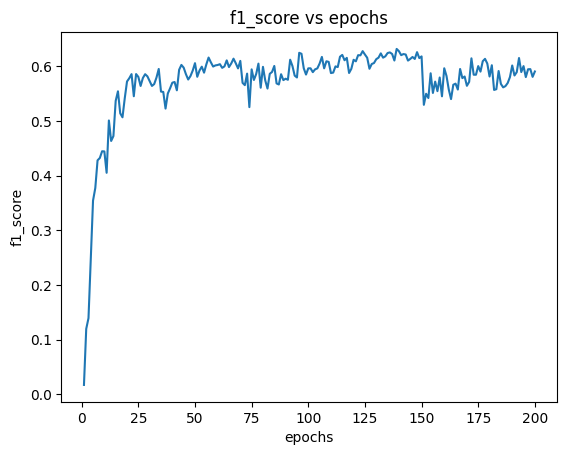

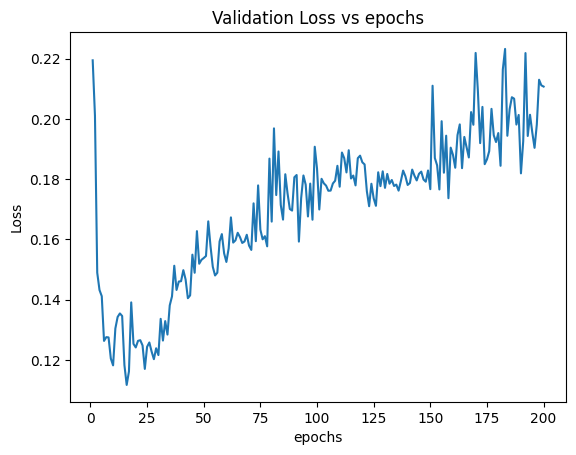

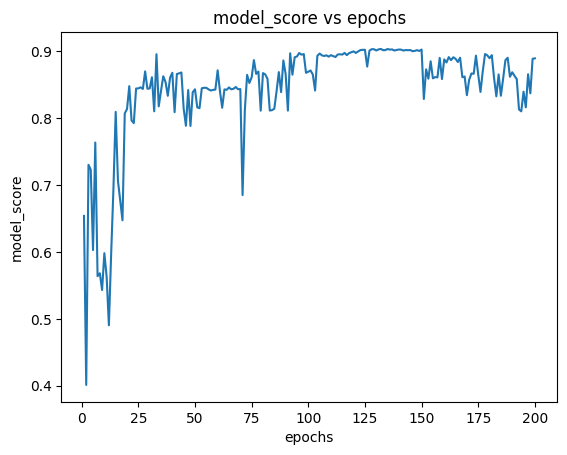

In [6]:
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,k+1), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

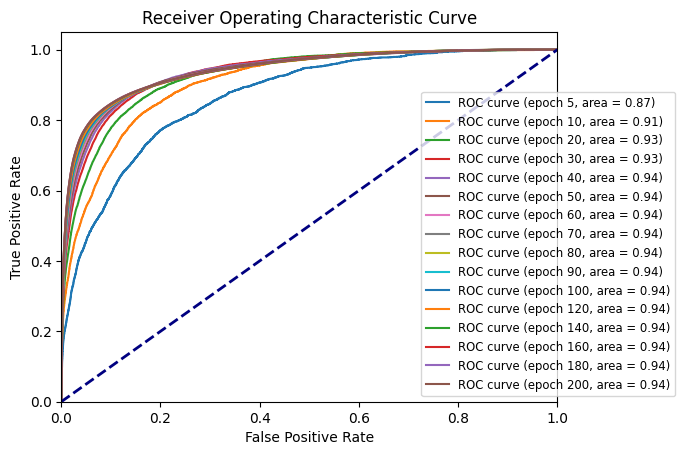

In [7]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [8]:
# model.eval()
# val_preds, val_labels = [], []
# heatmap_images = []  # Store heatmap images for positive samples with AUC score < 1
# with torch.no_grad():
#     for images, labels in tqdm(val_dataloader):
#         images, labels = images.to(device), labels.to(device)
            
#         # Forward pass
#         outputs = model(images)
#         outputs = torch.sigmoid(outputs)
        
#         # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
#         val_preds += outputs.tolist()
#         val_labels += labels.tolist()

#         # Generate heatmaps for positive samples with AUC score < 1
#         for idx, label in enumerate(labels):
#             if roc_auc_score([label.item()], [outputs[idx].item()]) < 1:
#                 # Convert the image to numpy array and normalize
#                 image = images[idx].cpu().numpy().transpose(1, 2, 0)
#                 image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#                 # Resize the image to match the input size of the model
#                 image = cv2.resize(image, (image_size, image_size))

#                 # Generate the heatmap
#                 heatmap = cam_generate(model, image, label.item())

#                 # Normalize the heatmap
#                 heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#                 # Store the heatmap image
#                 heatmap_images.append(heatmap)

# val_labels = np.array(val_labels)
# val_preds = np.array(val_preds)
# threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# # Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
# metrics_dict = {}
# for label in range(num_classes):
#     precision, recall, _ = precision_recall_curve(val_labels[:, label], thresholded_val_preds[:, label])
#     auc = roc_auc_score(val_labels[:, label], val_preds[:, label])
#     f1 = f1_score(val_labels[:, label], thresholded_val_preds[:, label], average='binary', zero_division=1)
#     metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}

# # Print the dictionary in tabular format using the tabulate library
# headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
# table = []
# for label in range(num_classes):
#     row = [label]
#     for metric in ['Precision', 'Recall', 'F1', 'AUC']:
#         values = metrics_dict[label][metric]
#         if values.size > 0:
#             value_str = '{:.4f}'.format(values.mean(), values.max())
#         else:
#             value_str = '0.00'
#         row.append(value_str)
#     table.append(row)

# print(tabulate(table, headers=headers))

# # Visualize the heatmap images
# for idx, heatmap_image in enumerate(heatmap_images):
#     cv2.imshow(f"Heatmap {idx}", heatmap_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.9474
      1       0.525     0.5     0       1
      2       0.6833    0.6667  1       1
      3       0.525     0.5     0       0.9474
      4       0.525     0.5     0       1
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.6833    0.6667  1       1
      8       0.5167    0.6667  0.6667  0.9474
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.525     0.5     0       1
     12       0.35      0.3333  0       0.9474
     13       0.5167    0.6667  0.6667  1
     14       0.35      0.3333  0       0.9474
     15       0.35      0.3333  0       0.9474
     16       0.35      0.3333  0       0.7895
     17       0.35      0.3333  0       0.6842
     18       0.6833    0.6667  1       1
     19       0.7       0.6667  1       1
